# Spoint tutorial: Deconvolution of cell types composition on mouse brain ST dataset

July 2023

Dataset: 75 ST slices of mouse brain ([here](https://zenodo.org/record/8167488))

In [2]:
import pandas as pd
import scanpy as sc
import anndata
import os
from tqdm import tqdm 
import scanpy as sc
import numpy as np
import sys

## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in ``.obs``.

In [3]:
adata = sc.read('../data/ST_mouse_brain/mouse_brain_st.h5ad')
scadata = sc.read_h5ad('../data/ST_mouse_brain/scRNA_Mouse_Nervous_System.h5ad')

In [4]:
scadata.var_names_make_unique()
scadata.obs_names_make_unique()

## Initialize and train the Spoint model

In this step, we initialize the Spoint model using anndata objects for scRNA-seq and ST as input. The``celltype_key`` parameter represents the column name of the cell type annotation in the .obs attribute of the scRNA-seq anndata object. The ``sm_size`` parameter controls the number of simulated spots, and it is important to have a sufficient ``sm_size`` for accurate prediction. However, it should be noted that increasing the ``sm_size`` will also increase the simulation and training time. In general, we recommend setting ``sm_size`` to a value greater than 100,000.

In [5]:
import SPACEL
from SPACEL.setting import set_environ_seed
set_environ_seed()
from SPACEL import Spoint

Setting environment seed: 42
Using GPU: 1


Global seed set to 0


In [6]:
spoint_model = Spoint.init_model(scadata,adata,celltype_key='Description',sm_size=500000,use_gpu=True,n_threads=2)
spoint_model.train(max_steps=5000, batch_size=1024)

Setting global seed: 42
### Finding marker genes...
Adrenergic cell groups of the medulla              200
Noradrenergic neurons of the medulla               200
Non-telencephalon astrocytes, fibrous              200
Non-border Cck interneurons, hippocampus           200
Non-border Cck interneurons, cortex/hippocampus    200
                                                  ... 
Neuroblasts, cerebellum                            122
Purkinje cells                                     116
Granular layer interneurons, cerebellum             67
Pmch neurons, hypothalamus                          46
Neuroblast-like, habenula                           18
Name: Description, Length: 103, dtype: int64
### Used gene numbers: 5723
### Initializing sample probability
### Genetating simulated spatial data using scRNA data with mode: unbalance
### Genetating simulated spatial data using scRNA data with mode: sqrt
### Genetating simulated spatial data using scRNA data with mode: balance


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 100/100: 100%|██████████| 100/100 [51:24<00:00, 32.87s/it, loss=3.79e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [51:24<00:00, 30.84s/it, loss=3.79e+03, v_num=1]


Step 5000: test inf loss=-0.787, train inf loss=-0.736, test rec loss=-0.381, train rec loss=-0.345, st test rec loss=-0.399, mmd loss=0.015: 100%|██████████| 5000/5000 [4:36:21<00:00,  3.32s/it]  


Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a DataFrame object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the .obs attribute.

In [7]:
pre = spoint_model.deconv_spatial()
st_ad = spoint_model.st_ad
st_ad.write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

## Visualization results

As a demonstration, we plotted the predicted compositions of cell types on a slice, where the cell types are selected as the top 20 with the highest proportion within each spot.

In [8]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

In [9]:
st_ad = st_ad[st_ad.obs.slice==37]
celltype = st_ad.obs.loc[:,pre.columns].max(0)

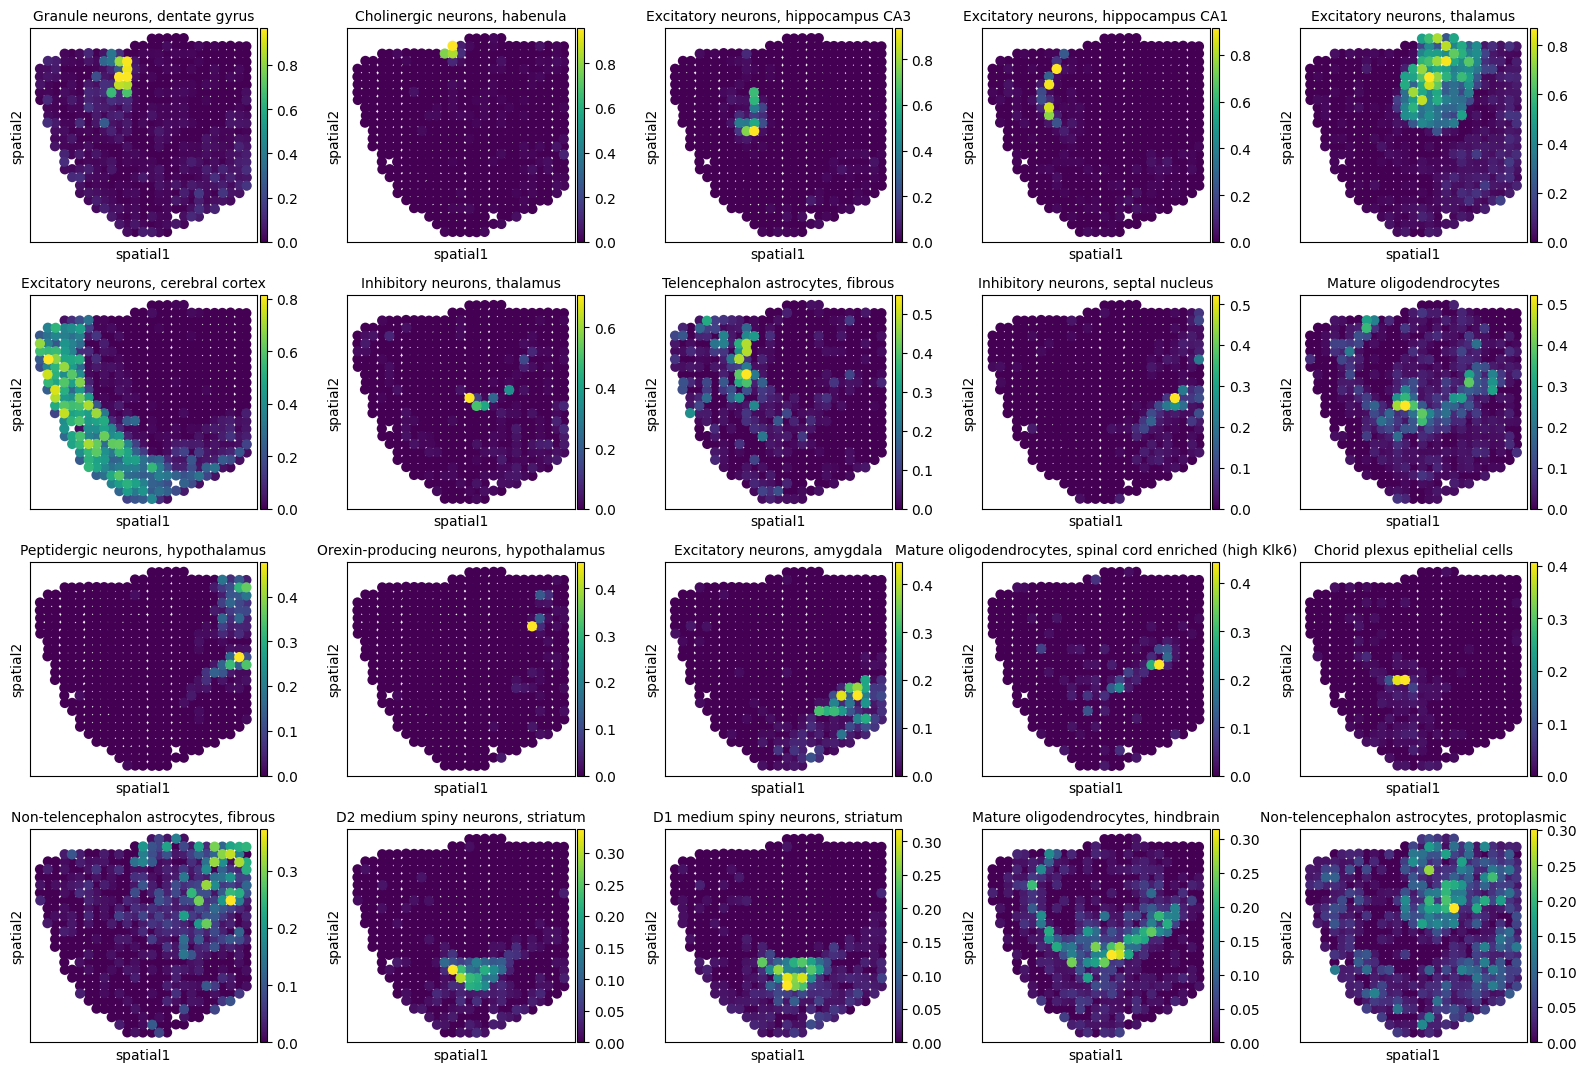

In [10]:
sc.pl.embedding(st_ad,color=celltype.sort_values(ascending=False)[:20].index,basis='spatial',ncols=5)